In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Leer los datos

In [2]:
!head -n 5 household_power_consumption.txt

Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000
16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000
16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000


Podemos ver que los datos están separados por punto y coma (;)

(low_memory como False por un Warning sobre dificultades en entender el tipo de dato de cada columna, lo cual ocurre por la gran cantidad de registros)

In [3]:
df = pd.read_csv('household_power_consumption.txt',
                 sep=';', low_memory=False)
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   2075259 non-null  object 
 1   Time                   2075259 non-null  object 
 2   Global_active_power    2075259 non-null  object 
 3   Global_reactive_power  2075259 non-null  object 
 4   Voltage                2075259 non-null  object 
 5   Global_intensity       2075259 non-null  object 
 6   Sub_metering_1         2075259 non-null  object 
 7   Sub_metering_2         2075259 non-null  object 
 8   Sub_metering_3         2049280 non-null  float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


Toca descifrar por qué Pandas no está leyendo las columnas numéricas como Floats:

In [4]:
print(sorted(df.Global_active_power.unique())[:10])
print(sorted(df.Global_active_power.unique())[-10:])

['0.076', '0.078', '0.080', '0.082', '0.084', '0.086', '0.088', '0.090', '0.092', '0.094']
['9.708', '9.714', '9.718', '9.724', '9.726', '9.732', '9.922', '9.938', '9.994', '?']


¡Ahí está! Es por esos valores "?"

Vamos a leer otra vez los datos, teniendo ello en cuenta.

In [5]:
df = pd.read_csv('household_power_consumption.txt',
                 sep=';', low_memory=False, na_values=[np.nan, '?'])
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   2075259 non-null  object 
 1   Time                   2075259 non-null  object 
 2   Global_active_power    2049280 non-null  float64
 3   Global_reactive_power  2049280 non-null  float64
 4   Voltage                2049280 non-null  float64
 5   Global_intensity       2049280 non-null  float64
 6   Sub_metering_1         2049280 non-null  float64
 7   Sub_metering_2         2049280 non-null  float64
 8   Sub_metering_3         2049280 non-null  float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


Y, ahora, a indexar los datos de manera temporal:

In [6]:
df.index = pd.to_datetime(df.Date + '-' + df.Time,
                          format='%d/%m/%Y-%H:%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


# Análisis exploratorio

Primero veamos las distribuciones de las variables

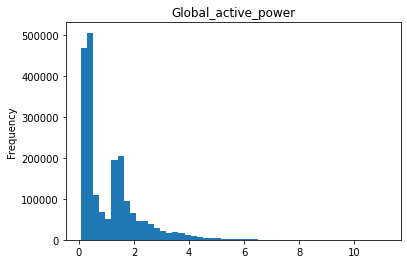

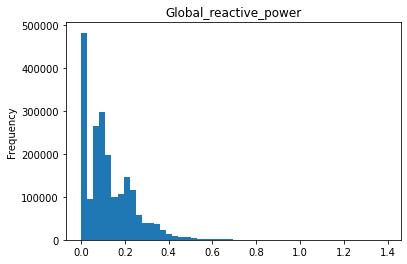

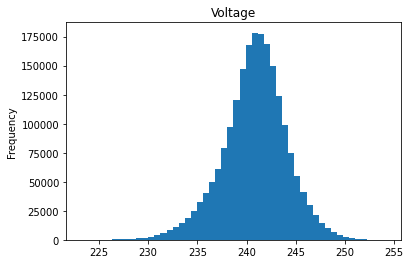

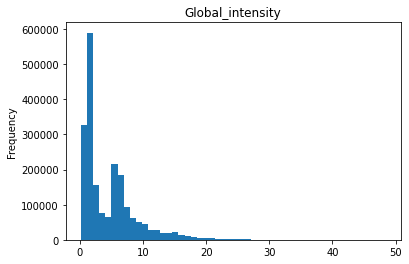

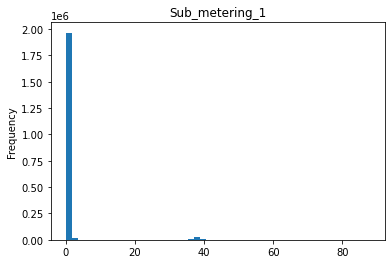

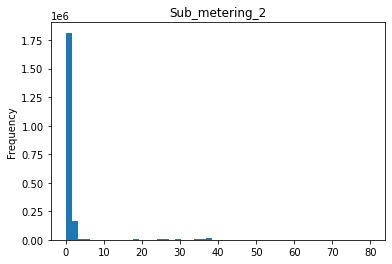

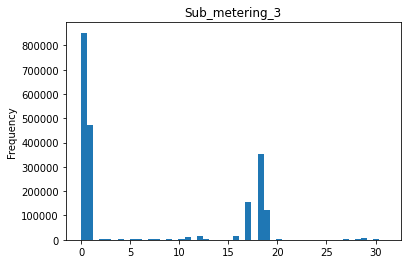

In [7]:
for col in df.columns:
    df[col].plot.hist(bins=50, title=col)
    plt.show()

Leyendo, lo que más nos debe interesar es "Global_active_power", pues realmente representa el total de energía utilizada (por minuto) en el hogar donde se recogieron estos datos. 

Dicha columna es la suma de los 3 sub-meterings, que representan 1 cocina, 2 lavandería, y 3 calefacción o aire acondicionado (más un sobrante, que sería "otros").

Por ende, vamos a iniciar analizando esa columna.

In [8]:
print(f'Hay {df.Global_active_power.isnull().sum()} valores nulos,',
      'veamos dónde están.')

Hay 25979 valores nulos, veamos dónde están.


In [9]:
df.index.year.value_counts()

2008    527040
2009    525600
2007    525600
2010    475023
2006     21996
dtype: int64

In [10]:
for y in df.index.year.unique():
    n_nulos = df.loc[str(y), 'Global_active_power'].isnull().sum()
    n_año = len(df.loc[str(y), 'Global_active_power'])
    print(f'{y}: {n_nulos} nulos ({round(100*n_nulos/n_año, 2)}%)')

2006: 4 nulos (0.02%)
2007: 3931 nulos (0.75%)
2008: 135 nulos (0.03%)
2009: 4280 nulos (0.81%)
2010: 17629 nulos (3.71%)


Ahora dentro del 2010 (el año con más nulos):

In [11]:
for m in sorted(df.index.month.unique()):
    try:
        n_nulos = df.loc[f'2010-{m}', 'Global_active_power'].isnull().sum()
    except KeyError:
        continue
    n_mes = len(df.loc[f'2010-{m}', 'Global_active_power'])
    print(f'{m}: {n_nulos} nulos ({round(100*n_nulos/n_mes, 2)}%)')

1: 3131 nulos (7.01%)
2: 2 nulos (0.0%)
3: 2027 nulos (4.54%)
4: 1 nulos (0.0%)
5: 1 nulos (0.0%)
6: 2 nulos (0.0%)
7: 1 nulos (0.0%)
8: 7226 nulos (16.19%)
9: 5237 nulos (12.12%)
10: 1 nulos (0.0%)
11: 0 nulos (0.0%)


Y ahora dentro de agosto (2010)

In [12]:
for d in sorted(df.index.day.unique()):
    try:
        n_nulos = df.loc[f'2010-8-{d}', 'Global_active_power'].isnull().sum()
    except KeyError:
        continue
    n_dia = len(df.loc[f'2010-8-{d}', 'Global_active_power'])
    print(f'{d}: {n_nulos} nulos ({round(100*n_nulos/n_dia, 2)}%)')

1: 0 nulos (0.0%)
2: 0 nulos (0.0%)
3: 0 nulos (0.0%)
4: 0 nulos (0.0%)
5: 0 nulos (0.0%)
6: 0 nulos (0.0%)
7: 0 nulos (0.0%)
8: 0 nulos (0.0%)
9: 0 nulos (0.0%)
10: 0 nulos (0.0%)
11: 0 nulos (0.0%)
12: 0 nulos (0.0%)
13: 0 nulos (0.0%)
14: 0 nulos (0.0%)
15: 0 nulos (0.0%)
16: 0 nulos (0.0%)
17: 178 nulos (12.36%)
18: 1440 nulos (100.0%)
19: 1440 nulos (100.0%)
20: 1440 nulos (100.0%)
21: 1440 nulos (100.0%)
22: 1288 nulos (89.44%)
23: 0 nulos (0.0%)
24: 0 nulos (0.0%)
25: 0 nulos (0.0%)
26: 0 nulos (0.0%)
27: 0 nulos (0.0%)
28: 0 nulos (0.0%)
29: 0 nulos (0.0%)
30: 0 nulos (0.0%)
31: 0 nulos (0.0%)


Viendo esto, se me ocurre que una forma razonable de imputar los vacíos sería utilizando el dato de exactamente 8 días atrás (o el día anterior si eso no es posible)

In [13]:
k=0
one_day = 60 * 24
one_week = one_day * 7

for ii, dt in enumerate(df.index):
    if not np.isnan(df.iloc[ii, 0]):
        continue
    #print(str(ii), dt)
    #print(df.iloc[ii, 0])
    if ii >= one_week:
        #print(df.iloc[ii - one_week, 0])
        df.iloc[ii, 0] = df.iloc[ii - one_week, 0]
    else:
        #print(df.iloc[ii - one_day, 0])
        df.iloc[ii, 0] = df.iloc[ii - one_day, 0]
    #print()

In [14]:
df.Global_active_power.isnull().sum()

0

Ahora, ya sin datos vacíos, veamos cómo se comporta dicha variable

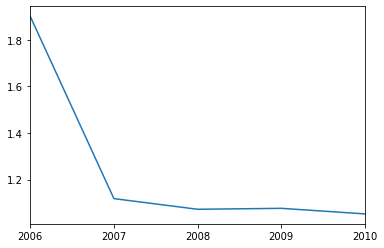

In [15]:
df.Global_active_power.resample('Y').mean().plot()

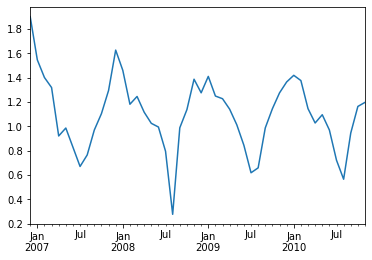

In [16]:
df.Global_active_power.resample('m').mean().plot()

No alcanzo a hacer mucho más, pero un par de observaciones:
- Por alguna razón el punto alto es en 2006, justo cuando se empezo a medir (¿lo que se mide se gestiona? ;) )
- Existe temporalidad anual muy clara, con el gasto máximo en invierno, y el mínimo en verano (¿tal vez el gasto más fuerte es calefacción? bueno, eso sí lo alcanzo a confirmar \[siguiente celda\]).

In [17]:
df[[col for col in df.columns if col.startswith('Sub')]].sum(axis=0)

Sub_metering_1     2299135.0
Sub_metering_2     2661031.0
Sub_metering_3    13235167.0
dtype: float64